# **Imports 📢**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Read Dataset

In [2]:
!unzip ./data/mobile_price.zip -d ./data/

Archive:  ./data/mobile_price.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [3]:
df = pd.read_csv('./data/train.csv')
X = df.drop('price_range', axis=1)
y = df['price_range']

## Split

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

## Preprocess

In [5]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## Dataloader

In [6]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, 20, True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# **Model 🧠**

In [7]:
num_feats = 20
num_class = 4

h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      # nn.Dropout(0.5),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

In [8]:
model[0].bias

Parameter containing:
tensor([-0.1268, -0.0706,  0.1967, -0.1385, -0.0111,  0.1759, -0.0303, -0.2009,
        -0.0556,  0.0363, -0.1720, -0.1733,  0.1548,  0.2051,  0.1761, -0.0544,
         0.1476, -0.0816, -0.0665, -0.0310, -0.1736,  0.2070,  0.0119,  0.1354,
         0.2230,  0.1775, -0.1456, -0.1651, -0.0331,  0.1852,  0.0389,  0.1010,
         0.0697,  0.1575, -0.1707,  0.1362, -0.1109,  0.0750, -0.1481,  0.2197,
         0.1781,  0.1410,  0.2131, -0.2040, -0.0129,  0.2012,  0.0205, -0.0957,
         0.0613, -0.1661, -0.0870, -0.2096, -0.0448, -0.1016,  0.0627, -0.2150,
         0.0443,  0.0782, -0.2017,  0.1248,  0.0560,  0.1186, -0.0624, -0.0693],
       requires_grad=True)

# **Loss & Optimizer ⚖️**

In [9]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=1e-4)    # L2Regularization

# **Device ⚙️**

In [10]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = model.to(device)

# **Utils 🧰**

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [13]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_class).to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())

  return model, loss_train.avg, acc_train.compute().item()

In [14]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_class).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

  return loss_valid.avg, acc_valid.compute()

# **Train**

In [12]:
for i in tqdm(range(50000000)):
  j = i**2

100%|██████████| 50000000/50000000 [00:16<00:00, 3016269.31it/s]


In [15]:
num_epochs = 100

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)

  loss_valid, acc_valid = evaluate(model,
                                   valid_loader,
                                   loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}\n')

Epoch 0:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 100.69batch/s, accuracy=42.1, loss=1.32]


Valid: Loss=1.147, Accuracy=0.5933



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 157.61batch/s, accuracy=71.9, loss=0.815]


Valid: Loss=0.5466, Accuracy=0.8733



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 156.68batch/s, accuracy=88.6, loss=0.424]


Valid: Loss=0.3395, Accuracy=0.8867



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 165.41batch/s, accuracy=92.4, loss=0.27] 


Valid: Loss=0.2502, Accuracy=0.91



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 162.05batch/s, accuracy=93.9, loss=0.195]


Valid: Loss=0.2115, Accuracy=0.9117



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 146.99batch/s, accuracy=94.9, loss=0.157]


Valid: Loss=0.2049, Accuracy=0.9217



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 164.33batch/s, accuracy=97.3, loss=0.124]


Valid: Loss=0.177, Accuracy=0.9217



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 162.82batch/s, accuracy=97.1, loss=0.106] 


Valid: Loss=0.1632, Accuracy=0.9333



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 162.26batch/s, accuracy=97.4, loss=0.0901]


Valid: Loss=0.1758, Accuracy=0.9283



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 164.32batch/s, accuracy=97.4, loss=0.0797]


Valid: Loss=0.1707, Accuracy=0.925



Epoch 10: 100%|██████████| 70/70 [00:00<00:00, 157.62batch/s, accuracy=98.9, loss=0.0659]


Valid: Loss=0.1595, Accuracy=0.93



Epoch 11: 100%|██████████| 70/70 [00:00<00:00, 140.91batch/s, accuracy=98.7, loss=0.0561]


Valid: Loss=0.1645, Accuracy=0.9317



Epoch 12: 100%|██████████| 70/70 [00:00<00:00, 144.95batch/s, accuracy=99.6, loss=0.047] 


Valid: Loss=0.1647, Accuracy=0.935



Epoch 13: 100%|██████████| 70/70 [00:00<00:00, 164.50batch/s, accuracy=99.6, loss=0.0425]


Valid: Loss=0.1685, Accuracy=0.9367



Epoch 14: 100%|██████████| 70/70 [00:00<00:00, 155.27batch/s, accuracy=99.6, loss=0.0359]


Valid: Loss=0.1892, Accuracy=0.915



Epoch 15: 100%|██████████| 70/70 [00:00<00:00, 163.05batch/s, accuracy=100, loss=0.0304]


Valid: Loss=0.1587, Accuracy=0.9367



Epoch 16: 100%|██████████| 70/70 [00:00<00:00, 158.16batch/s, accuracy=99.9, loss=0.0269]


Valid: Loss=0.1762, Accuracy=0.9283



Epoch 17: 100%|██████████| 70/70 [00:00<00:00, 127.62batch/s, accuracy=100, loss=0.0252]


Valid: Loss=0.1747, Accuracy=0.9367



Epoch 18: 100%|██████████| 70/70 [00:00<00:00, 131.17batch/s, accuracy=99.9, loss=0.0215]


Valid: Loss=0.1727, Accuracy=0.9317



Epoch 19: 100%|██████████| 70/70 [00:00<00:00, 131.41batch/s, accuracy=100, loss=0.0178]


Valid: Loss=0.1672, Accuracy=0.93



Epoch 20: 100%|██████████| 70/70 [00:00<00:00, 133.57batch/s, accuracy=100, loss=0.0158]


Valid: Loss=0.1713, Accuracy=0.9367



Epoch 21: 100%|██████████| 70/70 [00:00<00:00, 106.38batch/s, accuracy=100, loss=0.0143]


Valid: Loss=0.1867, Accuracy=0.925



Epoch 22: 100%|██████████| 70/70 [00:00<00:00, 141.53batch/s, accuracy=99.9, loss=0.0136]


Valid: Loss=0.1791, Accuracy=0.9333



Epoch 23: 100%|██████████| 70/70 [00:00<00:00, 155.66batch/s, accuracy=100, loss=0.0123]


Valid: Loss=0.1787, Accuracy=0.9317



Epoch 24: 100%|██████████| 70/70 [00:00<00:00, 173.07batch/s, accuracy=100, loss=0.0113]


Valid: Loss=0.1803, Accuracy=0.925



Epoch 25: 100%|██████████| 70/70 [00:00<00:00, 172.02batch/s, accuracy=100, loss=0.00978]


Valid: Loss=0.1762, Accuracy=0.935



Epoch 26: 100%|██████████| 70/70 [00:00<00:00, 156.93batch/s, accuracy=100, loss=0.00923]


Valid: Loss=0.1856, Accuracy=0.93



Epoch 27: 100%|██████████| 70/70 [00:00<00:00, 165.47batch/s, accuracy=100, loss=0.0084] 


Valid: Loss=0.1824, Accuracy=0.9283



Epoch 28: 100%|██████████| 70/70 [00:00<00:00, 178.47batch/s, accuracy=100, loss=0.00815]


Valid: Loss=0.1918, Accuracy=0.925



Epoch 29: 100%|██████████| 70/70 [00:00<00:00, 176.16batch/s, accuracy=100, loss=0.00745]


Valid: Loss=0.1911, Accuracy=0.93



Epoch 30: 100%|██████████| 70/70 [00:00<00:00, 159.29batch/s, accuracy=100, loss=0.00726]


Valid: Loss=0.1869, Accuracy=0.9283



Epoch 31: 100%|██████████| 70/70 [00:00<00:00, 174.53batch/s, accuracy=100, loss=0.00683]


Valid: Loss=0.1889, Accuracy=0.925



Epoch 32: 100%|██████████| 70/70 [00:00<00:00, 170.56batch/s, accuracy=100, loss=0.00638]


Valid: Loss=0.1939, Accuracy=0.9217



Epoch 33: 100%|██████████| 70/70 [00:00<00:00, 177.21batch/s, accuracy=100, loss=0.00597]


Valid: Loss=0.1971, Accuracy=0.9233



Epoch 34: 100%|██████████| 70/70 [00:00<00:00, 174.11batch/s, accuracy=100, loss=0.00567]


Valid: Loss=0.1923, Accuracy=0.9283



Epoch 35: 100%|██████████| 70/70 [00:00<00:00, 170.80batch/s, accuracy=100, loss=0.00554]


Valid: Loss=0.1974, Accuracy=0.9267



Epoch 36: 100%|██████████| 70/70 [00:00<00:00, 149.69batch/s, accuracy=100, loss=0.00517]


Valid: Loss=0.1918, Accuracy=0.9283



Epoch 37: 100%|██████████| 70/70 [00:00<00:00, 143.04batch/s, accuracy=100, loss=0.00519]


Valid: Loss=0.2007, Accuracy=0.925



Epoch 38: 100%|██████████| 70/70 [00:00<00:00, 151.39batch/s, accuracy=100, loss=0.00483]


Valid: Loss=0.2007, Accuracy=0.925



Epoch 39: 100%|██████████| 70/70 [00:00<00:00, 156.15batch/s, accuracy=100, loss=0.00463]


Valid: Loss=0.2008, Accuracy=0.9267



Epoch 40: 100%|██████████| 70/70 [00:00<00:00, 149.62batch/s, accuracy=100, loss=0.00438]


Valid: Loss=0.1977, Accuracy=0.9267



Epoch 41: 100%|██████████| 70/70 [00:00<00:00, 142.46batch/s, accuracy=100, loss=0.00421]


Valid: Loss=0.1976, Accuracy=0.9267



Epoch 42: 100%|██████████| 70/70 [00:00<00:00, 156.17batch/s, accuracy=100, loss=0.00407]


Valid: Loss=0.1969, Accuracy=0.9267



Epoch 43: 100%|██████████| 70/70 [00:00<00:00, 158.74batch/s, accuracy=100, loss=0.00389]


Valid: Loss=0.2011, Accuracy=0.925



Epoch 44: 100%|██████████| 70/70 [00:00<00:00, 132.46batch/s, accuracy=100, loss=0.00382]


Valid: Loss=0.2023, Accuracy=0.9267



Epoch 45: 100%|██████████| 70/70 [00:00<00:00, 141.35batch/s, accuracy=100, loss=0.0037] 


Valid: Loss=0.2038, Accuracy=0.9233



Epoch 46: 100%|██████████| 70/70 [00:00<00:00, 154.19batch/s, accuracy=100, loss=0.00358]


Valid: Loss=0.2052, Accuracy=0.9267



Epoch 47: 100%|██████████| 70/70 [00:00<00:00, 192.71batch/s, accuracy=100, loss=0.00346]


Valid: Loss=0.2027, Accuracy=0.9283



Epoch 48: 100%|██████████| 70/70 [00:00<00:00, 202.87batch/s, accuracy=100, loss=0.00336]


Valid: Loss=0.2078, Accuracy=0.9233



Epoch 49: 100%|██████████| 70/70 [00:00<00:00, 195.90batch/s, accuracy=100, loss=0.00323]


Valid: Loss=0.2086, Accuracy=0.9267



Epoch 50: 100%|██████████| 70/70 [00:00<00:00, 190.96batch/s, accuracy=100, loss=0.00319]


Valid: Loss=0.2088, Accuracy=0.9267



Epoch 51: 100%|██████████| 70/70 [00:00<00:00, 200.55batch/s, accuracy=100, loss=0.00311]


Valid: Loss=0.2076, Accuracy=0.9267



Epoch 52: 100%|██████████| 70/70 [00:00<00:00, 162.38batch/s, accuracy=100, loss=0.00303]


Valid: Loss=0.2088, Accuracy=0.93



Epoch 53: 100%|██████████| 70/70 [00:00<00:00, 165.69batch/s, accuracy=100, loss=0.00296]


Valid: Loss=0.2053, Accuracy=0.9267



Epoch 54: 100%|██████████| 70/70 [00:00<00:00, 195.46batch/s, accuracy=100, loss=0.00284]


Valid: Loss=0.2138, Accuracy=0.9267



Epoch 55: 100%|██████████| 70/70 [00:00<00:00, 184.82batch/s, accuracy=100, loss=0.00279]


Valid: Loss=0.2117, Accuracy=0.9283



Epoch 56: 100%|██████████| 70/70 [00:00<00:00, 201.46batch/s, accuracy=100, loss=0.00271]


Valid: Loss=0.2107, Accuracy=0.925



Epoch 57: 100%|██████████| 70/70 [00:00<00:00, 197.14batch/s, accuracy=100, loss=0.00266]


Valid: Loss=0.2142, Accuracy=0.9267



Epoch 58: 100%|██████████| 70/70 [00:00<00:00, 199.39batch/s, accuracy=100, loss=0.00258]


Valid: Loss=0.2113, Accuracy=0.925



Epoch 59: 100%|██████████| 70/70 [00:00<00:00, 199.54batch/s, accuracy=100, loss=0.00257]


Valid: Loss=0.2146, Accuracy=0.9267



Epoch 60: 100%|██████████| 70/70 [00:00<00:00, 191.32batch/s, accuracy=100, loss=0.00247]


Valid: Loss=0.2163, Accuracy=0.9267



Epoch 61: 100%|██████████| 70/70 [00:00<00:00, 191.17batch/s, accuracy=100, loss=0.00242]


Valid: Loss=0.2137, Accuracy=0.925



Epoch 62: 100%|██████████| 70/70 [00:00<00:00, 197.68batch/s, accuracy=100, loss=0.00237]


Valid: Loss=0.2137, Accuracy=0.9267



Epoch 63: 100%|██████████| 70/70 [00:00<00:00, 193.71batch/s, accuracy=100, loss=0.00231]


Valid: Loss=0.2182, Accuracy=0.925



Epoch 64: 100%|██████████| 70/70 [00:00<00:00, 175.32batch/s, accuracy=100, loss=0.00229]


Valid: Loss=0.2153, Accuracy=0.925



Epoch 65: 100%|██████████| 70/70 [00:00<00:00, 196.38batch/s, accuracy=100, loss=0.00228]


Valid: Loss=0.2156, Accuracy=0.925



Epoch 66: 100%|██████████| 70/70 [00:00<00:00, 173.37batch/s, accuracy=100, loss=0.00224]


Valid: Loss=0.2188, Accuracy=0.9267



Epoch 67: 100%|██████████| 70/70 [00:00<00:00, 190.85batch/s, accuracy=100, loss=0.0022] 


Valid: Loss=0.2183, Accuracy=0.925



Epoch 68: 100%|██████████| 70/70 [00:00<00:00, 196.83batch/s, accuracy=100, loss=0.00215]


Valid: Loss=0.2172, Accuracy=0.925



Epoch 69: 100%|██████████| 70/70 [00:00<00:00, 168.91batch/s, accuracy=100, loss=0.00212]


Valid: Loss=0.2196, Accuracy=0.925



Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 140.26batch/s, accuracy=100, loss=0.00207]


Valid: Loss=0.2218, Accuracy=0.9267



Epoch 71: 100%|██████████| 70/70 [00:00<00:00, 139.91batch/s, accuracy=100, loss=0.00203]


Valid: Loss=0.2186, Accuracy=0.925



Epoch 72: 100%|██████████| 70/70 [00:00<00:00, 137.01batch/s, accuracy=100, loss=0.00202]


Valid: Loss=0.2203, Accuracy=0.9267



Epoch 73: 100%|██████████| 70/70 [00:00<00:00, 151.87batch/s, accuracy=100, loss=0.00196]


Valid: Loss=0.2225, Accuracy=0.9267



Epoch 74: 100%|██████████| 70/70 [00:00<00:00, 158.42batch/s, accuracy=100, loss=0.00194]


Valid: Loss=0.2218, Accuracy=0.925



Epoch 75: 100%|██████████| 70/70 [00:00<00:00, 155.19batch/s, accuracy=100, loss=0.00192]


Valid: Loss=0.2232, Accuracy=0.925



Epoch 76: 100%|██████████| 70/70 [00:00<00:00, 163.37batch/s, accuracy=100, loss=0.0019] 


Valid: Loss=0.2238, Accuracy=0.9233



Epoch 77: 100%|██████████| 70/70 [00:00<00:00, 134.41batch/s, accuracy=100, loss=0.00188]


Valid: Loss=0.223, Accuracy=0.925



Epoch 78: 100%|██████████| 70/70 [00:00<00:00, 144.50batch/s, accuracy=100, loss=0.00185]


Valid: Loss=0.2216, Accuracy=0.925



Epoch 79: 100%|██████████| 70/70 [00:00<00:00, 129.58batch/s, accuracy=100, loss=0.00182]


Valid: Loss=0.2237, Accuracy=0.9233



Epoch 80: 100%|██████████| 70/70 [00:00<00:00, 131.22batch/s, accuracy=100, loss=0.00178]


Valid: Loss=0.2261, Accuracy=0.9267



Epoch 81: 100%|██████████| 70/70 [00:00<00:00, 149.12batch/s, accuracy=100, loss=0.00176]


Valid: Loss=0.2263, Accuracy=0.925



Epoch 82: 100%|██████████| 70/70 [00:00<00:00, 159.84batch/s, accuracy=100, loss=0.00173]


Valid: Loss=0.2258, Accuracy=0.925



Epoch 83: 100%|██████████| 70/70 [00:00<00:00, 139.73batch/s, accuracy=100, loss=0.00171]


Valid: Loss=0.2268, Accuracy=0.9267



Epoch 84: 100%|██████████| 70/70 [00:00<00:00, 128.17batch/s, accuracy=100, loss=0.00172]


Valid: Loss=0.2288, Accuracy=0.925



Epoch 85: 100%|██████████| 70/70 [00:00<00:00, 160.70batch/s, accuracy=100, loss=0.00167]


Valid: Loss=0.2258, Accuracy=0.9233



Epoch 86: 100%|██████████| 70/70 [00:00<00:00, 158.41batch/s, accuracy=100, loss=0.00167]


Valid: Loss=0.2269, Accuracy=0.9233



Epoch 87: 100%|██████████| 70/70 [00:00<00:00, 169.49batch/s, accuracy=100, loss=0.00165]


Valid: Loss=0.2277, Accuracy=0.925



Epoch 88: 100%|██████████| 70/70 [00:00<00:00, 114.97batch/s, accuracy=100, loss=0.0016] 


Valid: Loss=0.23, Accuracy=0.9283



Epoch 89: 100%|██████████| 70/70 [00:00<00:00, 120.35batch/s, accuracy=100, loss=0.00162]


Valid: Loss=0.2287, Accuracy=0.9267



Epoch 90: 100%|██████████| 70/70 [00:00<00:00, 162.62batch/s, accuracy=100, loss=0.00159]


Valid: Loss=0.2288, Accuracy=0.9233



Epoch 91: 100%|██████████| 70/70 [00:00<00:00, 170.23batch/s, accuracy=100, loss=0.00157]


Valid: Loss=0.2296, Accuracy=0.9233



Epoch 92: 100%|██████████| 70/70 [00:00<00:00, 159.41batch/s, accuracy=100, loss=0.00155]


Valid: Loss=0.2286, Accuracy=0.9267



Epoch 93: 100%|██████████| 70/70 [00:00<00:00, 154.19batch/s, accuracy=100, loss=0.00155]


Valid: Loss=0.2298, Accuracy=0.925



Epoch 94: 100%|██████████| 70/70 [00:00<00:00, 139.34batch/s, accuracy=100, loss=0.00153]


Valid: Loss=0.2307, Accuracy=0.9233



Epoch 95: 100%|██████████| 70/70 [00:00<00:00, 124.24batch/s, accuracy=100, loss=0.00151]


Valid: Loss=0.2307, Accuracy=0.925



Epoch 96: 100%|██████████| 70/70 [00:00<00:00, 147.91batch/s, accuracy=100, loss=0.0015] 


Valid: Loss=0.2319, Accuracy=0.925



Epoch 97: 100%|██████████| 70/70 [00:00<00:00, 149.98batch/s, accuracy=100, loss=0.00149]


Valid: Loss=0.2303, Accuracy=0.925



Epoch 98: 100%|██████████| 70/70 [00:00<00:00, 148.48batch/s, accuracy=100, loss=0.00148]


Valid: Loss=0.2332, Accuracy=0.925



Epoch 99: 100%|██████████| 70/70 [00:00<00:00, 132.16batch/s, accuracy=100, loss=0.00146]


Valid: Loss=0.2312, Accuracy=0.925



# **Plot**

### Loss

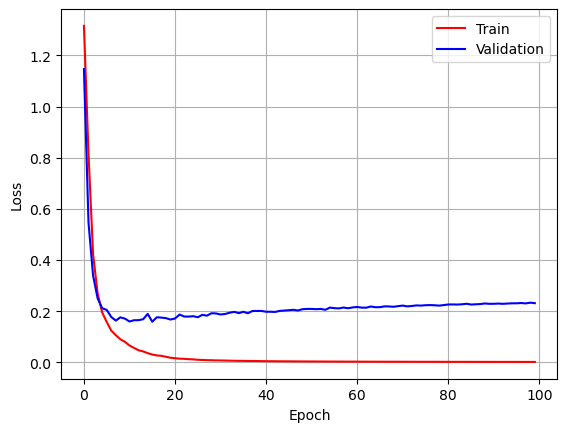

In [16]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

### Accuracy

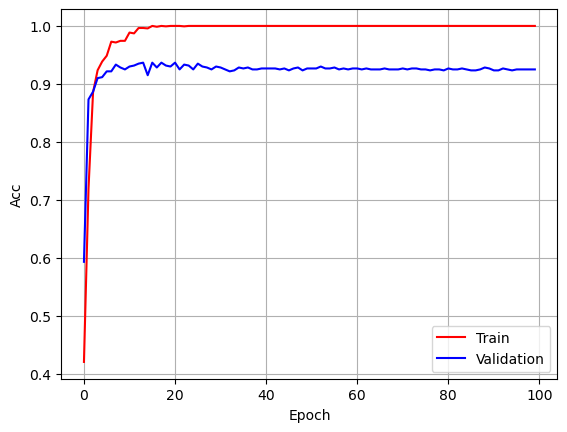

In [17]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [18]:
state_dict = model.state_dict()

In [20]:
!mkdir ./out/

In [21]:
torch.save(state_dict, './out/weights.pt')

In [22]:
wb = torch.load('./out/weights.pt')
model.load_state_dict(wb)

<All keys matched successfully>

# **Efficient way for set hyperparams 🔨**

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
x_batch, y_batch = next(iter(train_loader))
yp = model(x_batch)
loss_fn(yp, y_batch)

tensor(1.4280, grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [ ]:
mini_train_dataset, _ = random_split(train_dataset, (100, len(train_dataset)-100))
mini_loader = DataLoader(mini_train_dataset, 20, shuffle=True)

In [ ]:
for epoch in range(500):
    model, _, _ = train_one_epoch(model, mini_loader, loss_fn, optimizer, epoch)

## Step 3: select best lr

Train all data for one epoch

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [ ]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
  model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))
  
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  print(f'LR={lr}')
  for epoch in range(5):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [ ]:
for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
  for wd in [0., 1e-4, 1e-5, 1e-6]:
    model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    print(f'LR={lr}, WD={wd}')
    for epoch in range(5):
      model, _, _ = train_one_epoch(model,
                                    train_loader, 
                                    loss_fn,
                                    optimizer, 
                                    epoch)
    print()
    # torch.save(...)

LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 105.63batch/s, accuracy=93.8, loss=0.186]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 107.88batch/s, accuracy=92.8, loss=0.212]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 84.07batch/s, accuracy=93.4, loss=0.208]



LR=0.1, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 91.00batch/s, accuracy=93.9, loss=0.203]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 68.46batch/s, accuracy=90.7, loss=0.23]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 64.15batch/s, accuracy=91.6, loss=0.218]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:02<00:00, 23.84batch/s, accuracy=92.8, loss=0.19]



LR=0.15, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 93.34batch/s, accuracy=93.4, loss=0.17]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.02batch/s, accuracy=89.1, loss=0.313]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 108.38batch/s, accuracy=90.2, loss=0.259]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 92.83batch/s, accuracy=90.4, loss=0.25]



LR=0.2, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 88.83batch/s, accuracy=87.4, loss=0.306]



LR=0.25, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 95.96batch/s, accuracy=89.4, loss=0.276]



LR=0.25, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.80batch/s, accuracy=87.4, loss=0.363]



LR=0.25, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 92.70batch/s, accuracy=89.8, loss=0.285]



LR=0.25, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 93.50batch/s, accuracy=90.5, loss=0.243] 



LR=0.3, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 91.82batch/s, accuracy=86, loss=0.321]



LR=0.3, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 89.63batch/s, accuracy=85.1, loss=0.398]



LR=0.3, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.12batch/s, accuracy=90.4, loss=0.243]



LR=0.3, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 90.13batch/s, accuracy=89.4, loss=0.253]

### Pretty table

In [ ]:
from prettytable import PrettyTable

l = [["Hassan", 21, "LUMS"], ["Ali", 22, "FAST"], ["Ahmed", 23, "UET"]]
table = PrettyTable(['Name', 'Age', 'University'])

for rec in l:
    table.add_row(rec)
    
print(table)

+--------+-----+------------+
|  Name  | Age | University |
+--------+-----+------------+
| Hassan |  21 |    LUMS    |
|  Ali   |  22 |    FAST    |
| Ahmed  |  23 |    UET     |
+--------+-----+------------+


## Step 5: train more epochs

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.15, weight_decay=1e-5)

In [ ]:
num_epochs = 20

In [ ]:
best_valid_loss = torch.inf

In [ ]:
for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn)

  if loss_valid < best_valid_loss:
    torch.save(model, 'model.pt')
    best_valid_loss = loss_valid
    
  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 100.64batch/s, accuracy=96, loss=0.106]


Valid: Loss = 0.3054, Acc = 0.8783



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 88.68batch/s, accuracy=94.4, loss=0.135]


Valid: Loss = 0.345, Acc = 0.8683



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 89.66batch/s, accuracy=94.3, loss=0.188]


Valid: Loss = 0.4065, Acc = 0.8467



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 91.78batch/s, accuracy=96.7, loss=0.0725]


Valid: Loss = 0.4162, Acc = 0.8533



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 86.84batch/s, accuracy=97.1, loss=0.0766]


Valid: Loss = 0.2891, Acc = 0.885



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 89.06batch/s, accuracy=97.6, loss=0.0652]


Valid: Loss = 0.4412, Acc = 0.8533



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 86.41batch/s, accuracy=97.1, loss=0.0813]


Valid: Loss = 0.2771, Acc = 0.8983



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 97.75batch/s, accuracy=98.1, loss=0.0533]


Valid: Loss = 0.2672, Acc = 0.91



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 90.75batch/s, accuracy=99.6, loss=0.0235]


Valid: Loss = 0.2386, Acc = 0.9117



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 101.47batch/s, accuracy=98.6, loss=0.0375]


Valid: Loss = 0.253, Acc = 0.9033

